## Libraries import

In [1]:
import os

## load dataset: TGS Salt Identification Challenge (HAVE NOT BEEN USED YET)

In [ ]:
! mkdir /root/.kaggle
! cp /content/drive/MyDrive/Colab-Notebooks/data/kaggle/kaggle.json /root/.kaggle/
! mkdir /content/drive/MyDrive/Colab-Notebooks/data/tgs-salt-identification-challenge
! cd /content/drive/MyDrive/Colab-Notebooks/data/tgs-salt-identification-challenge

mkdir: cannot create directory ‘/content/drive/MyDrive/Colab-Notebooks/data/tgs-salt-identification-challenge’: File exists


In [ ]:
os.chdir('/content/drive/MyDrive/Colab-Notebooks/data/tgs-salt-identification-challenge')

In [ ]:
! pwd

N
/content/drive/MyDrive/Colab-Notebooks/data/tgs-salt-identification-challenge


In [ ]:
! kaggle competitions download -c tgs-salt-identification-challenge

train.csv: Skipping, found more recently modified local copy (use --force to force download)
flamingo.zip: Skipping, found more recently modified local copy (use --force to force download)
competition_data.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
test.zip: Skipping, found more recently modified local copy (use --force to force download)
train.zip: Skipping, found more recently modified local copy (use --force to force download)
depths.csv: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
! unzip train.zip -d ./train
! unzip test.zip -d ./test
! unzip flamingo.zip -d ./flamingo
! unzip competition_data.zip -d ./competition_data

# [Problem 1] Learning / Estimation

### clone code

In [ ]:
os.chdir('/content/drive/MyDrive/Colab-Notebooks/')

In [3]:
! pwd

/content/drive/MyDrive/Colab-Notebooks/unet


In [ ]:
! git clone https://github.com/zhixuhao/unet.git

In [2]:
os.chdir('/content/drive/MyDrive/Colab-Notebooks/unet')

In [4]:
from model import *
from data import *

### training phase

The dataset should have 2 type of images: real images and masks.

In [5]:
# do data augmentation
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')
myGene = trainGenerator(2,'data/membrane/train','image','label',data_gen_args,save_to_dir = None)
# create unet model
model = unet()
#save parameters to .hdf5 file
model_checkpoint = ModelCheckpoint('unet_membrane.hdf5', monitor='loss',verbose=1, save_best_only=True)
#train
model.fit_generator(myGene,steps_per_epoch=100,epochs=2,callbacks=[model_checkpoint])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  from ipykernel import kernelapp as app


Found 30 images belonging to 1 classes.
Found 30 images belonging to 1 classes.
Epoch 1/2
100/100 [==============================] - ETA: 0s - loss: 0.4854 - accuracy: 0.7750 
Epoch 00001: loss improved from inf to 0.48544, saving model to unet_membrane.hdf5
100/100 [==============================] - 1274s 13s/step - loss: 0.4854 - accuracy: 0.7750
Epoch 2/2
100/100 [==============================] - ETA: 0s - loss: 0.3419 - accuracy: 0.8262 
Epoch 00002: loss improved from 0.48544 to 0.34188, saving model to unet_membrane.hdf5
100/100 [==============================] - 1282s 13s/step - loss: 0.3419 - accuracy: 0.8262


After finishing the training, the parameters is stored in ```unet_membrane.hdf5``` file. Then, in the testing phase, we load that file and predict the testing data.

### testing phase

In [6]:
#load testset
testGene = testGenerator("data/membrane/test")
#create training model
model = unet()
#load parameters from .hdf5 file from previous training
model.load_weights("unet_membrane.hdf5")
#predict
results = model.predict_generator(testGene,30,verbose=1)
#save the predicted result
saveResult("data/membrane/test",results)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


30/30 [==============================] - 51s 2s/step


### Result

In [18]:
from matplotlib import pyplot as plt
from PIL import Image

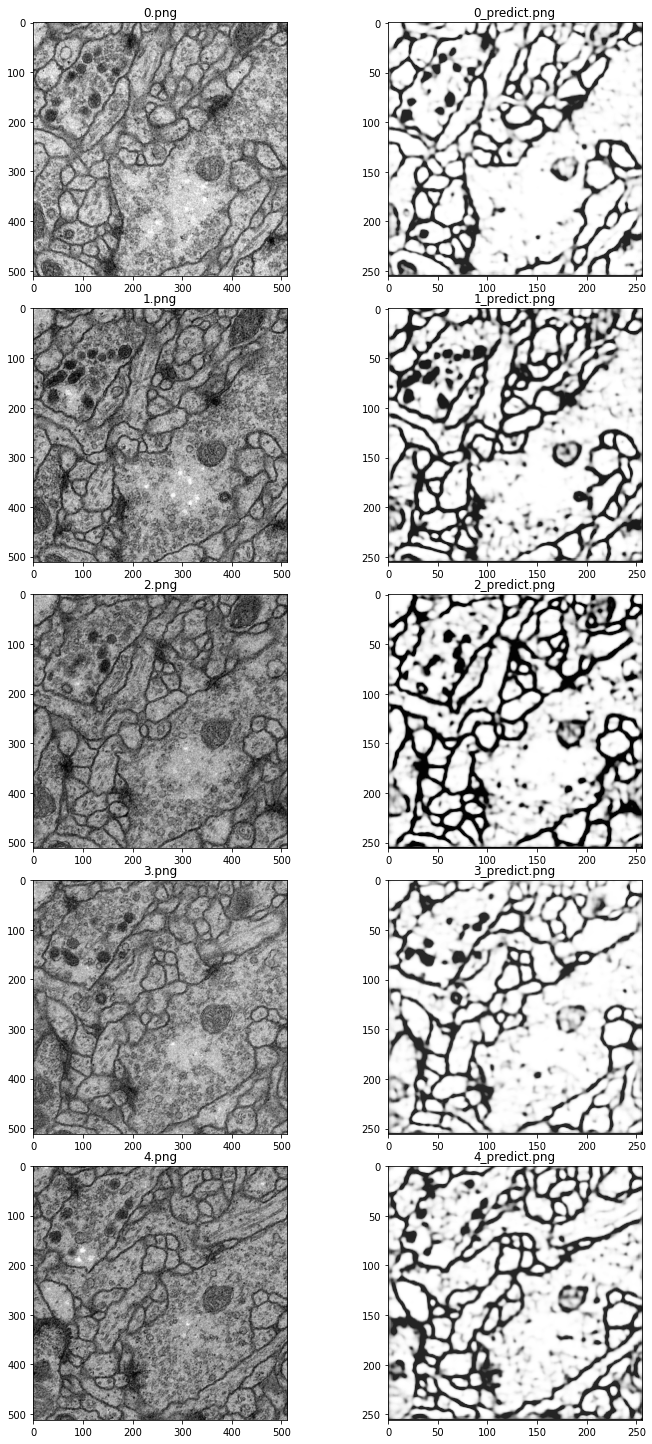

In [31]:
src_path = '/content/drive/MyDrive/Colab-Notebooks/unet/data/membrane/test'
n_img = 5

fig, axes = plt.subplots(n_img, 2, figsize=(10, 20))
fig.tight_layout()

for i in range(0, n_img):
    img = {
        'real': Image.open(os.path.join(src_path, '{}.png'.format(i))),
        'pred': Image.open(os.path.join(src_path, '{}_predict.png'.format(i)))
    }
    axes[i][0].set_title('{}.png'.format(i))
    axes[i][0].imshow(img['real'], cmap='gray')
    axes[i][1].set_title('{}_predict.png'.format(i))
    axes[i][1].imshow(img['pred'], cmap='gray')
    img['real'].close()
    img['pred'].close()

# [Problem 2] Code reading

<b>The architecture of the U-net</b>

Location: ```model.py```

Function: 
```python
def unet(pretrained_weights = None,input_size = (256,256,1))
```

<b>How up-conv is implemented by using Conv2D and UpSampling2D</b>

Location: ```model.py```

Function: 
```python
 up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
```

<b>Using Adam and binary_crossentropy for loss function, for binary classification</b>

Location: ```model.py```

Function: 

```python
model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
```

<b>concatination on contradict path and expensive path</b>

Location: ```model.py```

Function: 

```python
merge7 = concatenate([conv3,up7], axis = 3)
```

<b>generate training data by loading images and masks</b>

Location: ```data.py```

```python
def trainGenerator(batch_size,train_path,image_folder,mask_folder,aug_dict,image_color_mode = "grayscale",
                    mask_color_mode = "grayscale",image_save_prefix  = "image",mask_save_prefix  = "mask",
                    flag_multi_class = False,num_class = 2,save_to_dir = None,target_size = (256,256),seed = 1):
```